# Prerequisites

Let's install some packages before getting started with our model fine-tuning exercise - we're going to use our Notebook to fine-tune our model before deploying the model as an Endpoint

In [ ]:
%pip uninstall -y -q autogluon-multimodal autogluon-timeseries

In [ ]:
%pip install -q transformers==4.41.0

In [ ]:
%pip install -Uq torch==2.2.0+cu118 --index-url https://download.pytorch.org/whl/cu118

In [ ]:
%pip install -Uq bitsandbytes==0.43.0
%pip install -Uq peft==0.8.1
%pip install -Uq datasets==2.18.0 
%pip install -Uq tensorboardX==2.6.2.2
%pip install -Uq py7zr==0.21.0
%pip install -Uq einops==0.7.0

In [ ]:
%pip install -q accelerate==0.27.2

In [ ]:
%pip install -q huggingface_hub

In [ ]:
%pip install -q psutil pynvml

In [ ]:
%pip install -q mlflow==2.13.2 sagemaker-mlflow==0.1.0 accelerate==0.27.2 huggingface_hub psutil pynvml

In [ ]:
%pip install -q rouge bert_score

In [ ]:
%pip install -q streamlit

Restart Kernel auto-programatically using IPython Interface

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

# Introduction

In [ ]:
import os
import gc
import shutil
import torch
import re
import pandas as pd
from tqdm import tqdm
from accelerate import Accelerator
import transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    BitsAndBytesConfig
)
from peft import (
    prepare_model_for_kbit_training, 
    LoraConfig, 
    get_peft_model, 
    AutoPeftModelForCausalLM
)
import getpass
import boto3
import sagemaker
from datetime import datetime
from IPython.display import (
    display, 
    HTML, 
    Markdown
)
from utils.helper import (
    Metric_Evaluation, 
    pretty_print
)
from huggingface_hub import login

# Selecting an LLM

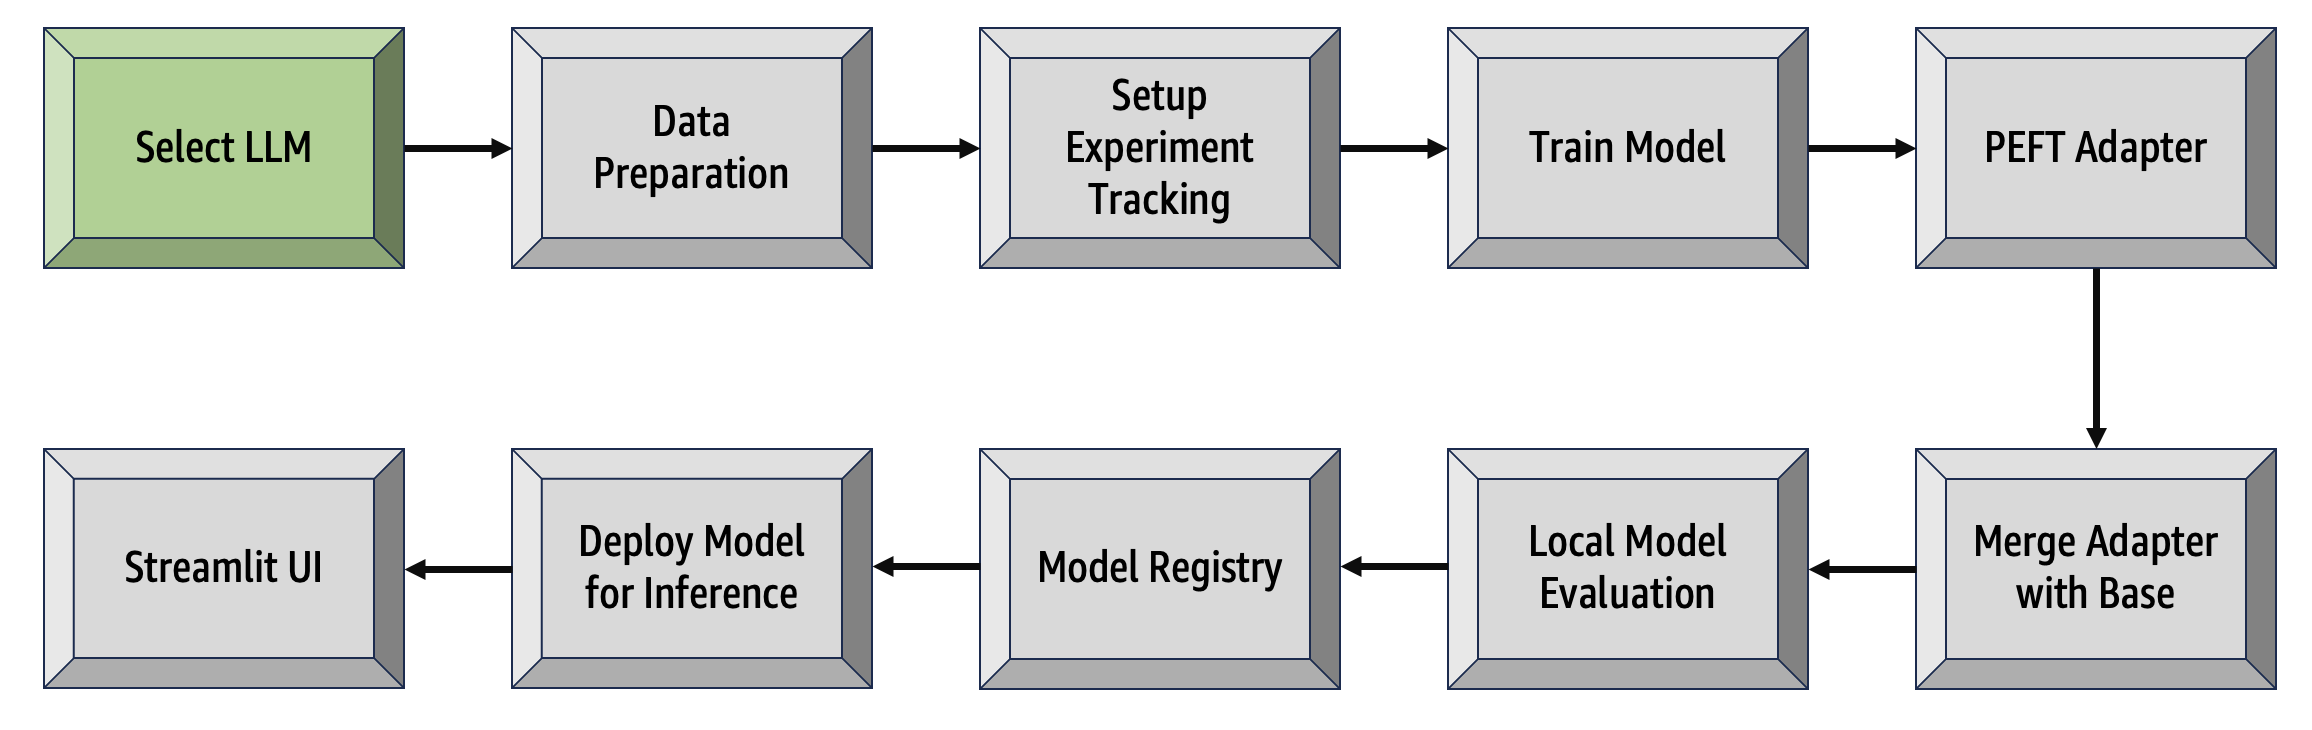

### Tips to Selecting an LLM

Selecting a Large Language Model can be a overwhelming. But here are a few rules to help you narrow down your models from a 100s of choices to a couple before making the choice.

1. **Filtering Choice my Task (Text Generation, Code Generation, Classification, Text to Image, etc..) and Language from a model hub** ([SageMaker JumpStart](https://aws.amazon.com/sagemaker/jumpstart/) or [HuggingFaceHub](https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard))

2. **Sorting by Popularity or Model Provider (ex: Meta Llama, Mistral AI, TIIUAE Falcon, Qwen, NousResearch, etc.)**

3. **Filter by Model Size - 1-10B (Small LLMs), 10-35B (Medium LLMs), 35B-80B (Large LLMs), 80B+ (Very Large LLMs)**

4. **Check Model Release Date**

5. **Deployment Destination**
   
6. **Responsible AI (Model Evaluation)**  

### [Why Choose LLama3?](https://llama.meta.com/llama3/)

Llama3 8B is the latest small variant of `meta-llama` family of models. It's performance exceeds similar models in the same category. Its open source*. It can be leveraged from HuggingFace Hub and SageMaker JumpStart.

![image.png](https://imageio.forbes.com/specials-images/imageserve/662202846cb84bb3a193445a/llama3/960x0.png?format=png&width=512)

## Setup

In [ ]:
sess = sagemaker.Session()
role = sagemaker.get_execution_role()

s3 = boto3.client('s3')
sm_client = boto3.client('sagemaker')

In [ ]:
# define some global variables
MLFLOW_EXPERIMENT_NAME = f"meta-Llama3-8b-Experiment-{datetime.now().strftime('%Y%m%d')}"
MODEL_PACKAGE_GROUP_NAME = "llama3-finance-8b"
TRACKING_SERVER_ARN = "arn:aws:sagemaker:us-east-1:811828458885:mlflow-tracking-server/mlflow-demos"

In [ ]:
hf_token = getpass.getpass()
login(token=hf_token)

## Load Model into Memory

##### Model Details
Meta developed and released the Meta Llama 3 family of large language models (LLMs), a collection of pretrained and instruction tuned generative text models in 8 and 70B sizes. The Llama 3 instruction tuned models are optimized for dialogue use cases and outperform many of the available open source chat models on common industry benchmarks.

[Read more about Llama3 8B from Model Card](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct)


##### Loading Quantized Model into GPU
![Quantization](https://huggingface.co/blog/assets/96_hf_bitsandbytes_integration/tf32-Mantissa-chart-hi-res-FINAL.png)

In [ ]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

model_cache_dir = f"/mnt/sagemaker-nvme/hf-models/{model_id}"

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True
)

# load model in float16 format
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
    cache_dir=model_cache_dir
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    model_id, 
    padding_side="left",
    add_eos_token=True
)
tokenizer.pad_token = tokenizer.eos_token
model.generation_config.pad_token_id = tokenizer.pad_token_id

In [ ]:
!nvidia-smi

## Run Vanilla Inference

In [ ]:
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
    {"role": "assistant", "content": "Who are you?"},
]

In [ ]:
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    tokenize=True
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

In [ ]:
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
output = tokenizer.decode(response, skip_special_tokens=True)

In [ ]:
pretty_print(output)

# Dataset

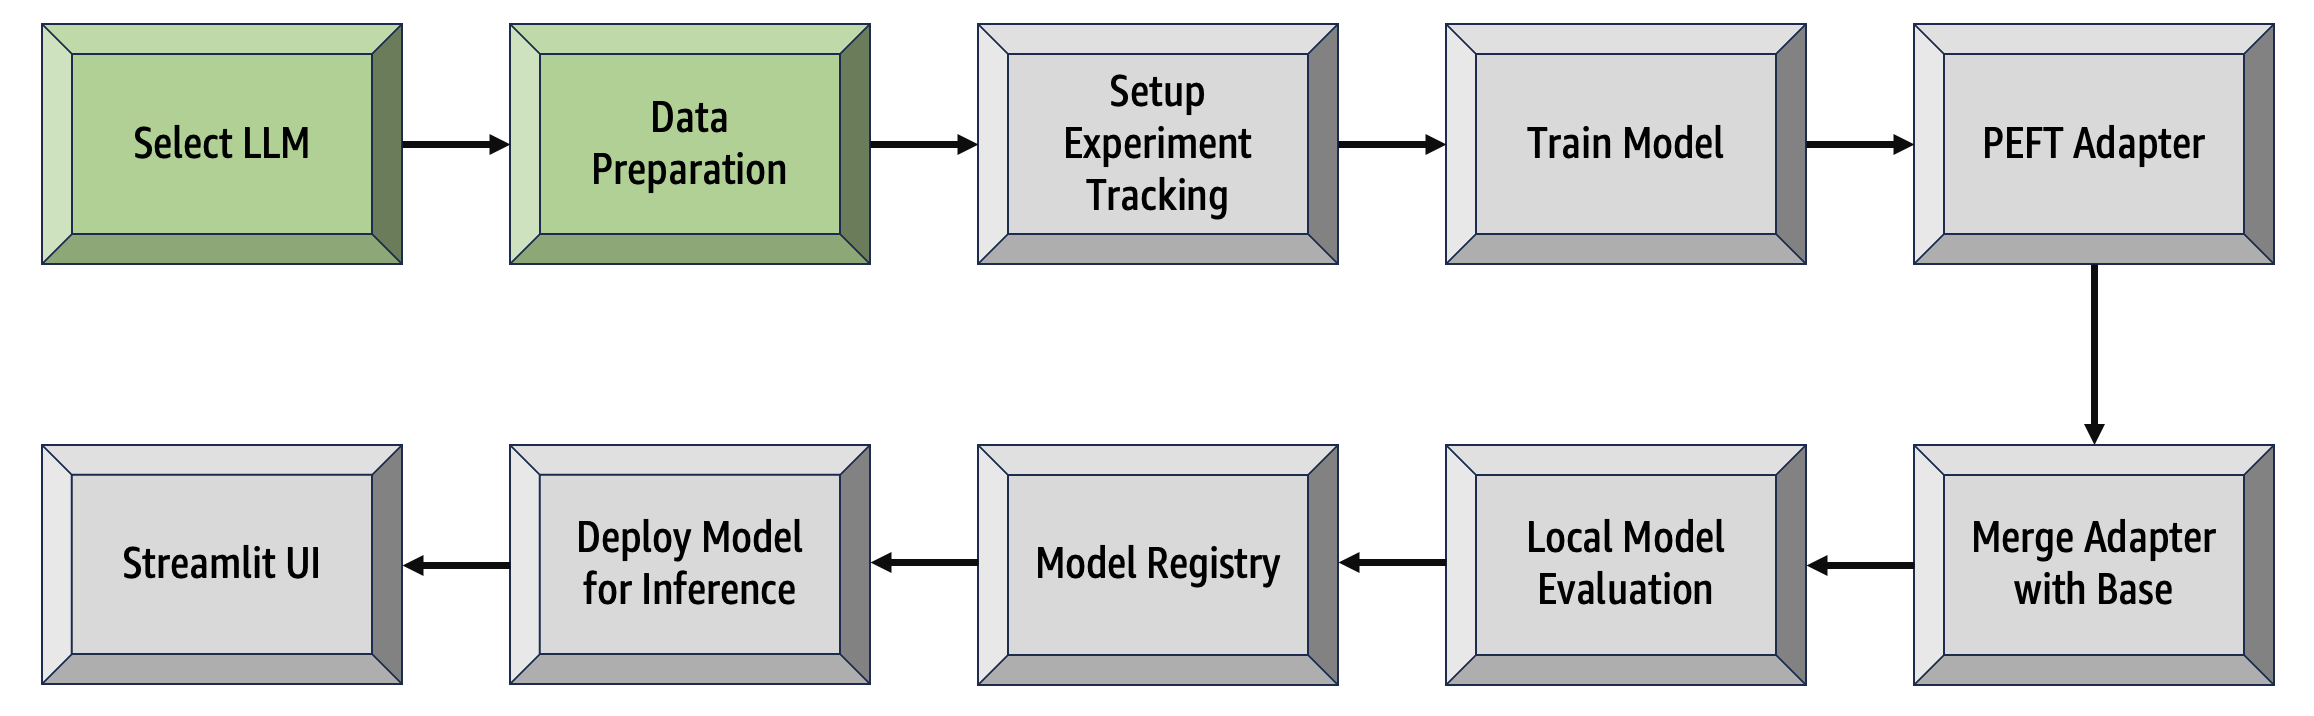

In [ ]:
import copy
from random import randrange
from random import randint
from datasets import Dataset, load_dataset

##### Dataset Information - [mrSoul7766/ECTSum](https://huggingface.co/datasets/mrSoul7766/ECTSum)

We're going to use an opensource dataset that showcases financial summarization. The summarization format is very specific and not easily emulated with an off-the-shelf Llama3

| Text    | Summary |
| -------- | ------- |
| For those of you that have not, it is available on the Investor Relations section of our website at investor. Non-GAAP net earnings and non-GAAP EPS, which have been adjusted for certain items which may affect the comparability of our performance with other companies. I'm very pleased with the strong start to 2021 and the positive momentum in revenue and margins we delivered in the first quarter, demonstrating the strong operating leverage in our business. Consolidated revenues increased 11.1\% year-over-year in our first full quarter as a stand-alone public company...  | q1 revenue rose 11.1 percent to \$481.1 million. q1 non-gaap earnings per share \$1.24. sees fy revenue \$1.725 billion to \$1.775 billion.    |
| Both are now available on the Investors section of our website, americanassetstrust.com. We are making great progress on all fronts as we focus our efforts on our rebound from COVID-19's impact, by enhancing and amenitizing existing properties, acquiring new accretive properties like Eastgate Office Park in Bellevue, which the team will talk about more in a bit, retaining and adding new customers to our portfolio...| compname reports q2 ffo per share $0.51. q2 ffo per share $0.51. |

In [ ]:
DATASET_NAME = "mrSoul7766/ECTSum"

In [ ]:
# Load dataset from the hub
train_dataset = load_dataset(
    DATASET_NAME, 
    split="train[:-100]"
).rename_column("text", "context")
validation_dataset = load_dataset(
    DATASET_NAME, 
    split="train[-100:]"
).rename_column("text", "context")
test_dataset = load_dataset(
    DATASET_NAME, 
    split="test"
).rename_column("text", "context")

print(f"===> Train dataset size: {len(train_dataset)}")
print(f"===> Validation dataset size: {len(validation_dataset)}")
print(f"===> Test dataset size: {len(test_dataset)}")

## Get Model Inference for Summarization

We are going to format user's input into `Llama3` prompt format using the format below.
```
Example Llama3 chat format,
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
    {"role": "assistant", "content": "Who are you?"},
]
```

In [ ]:
def llama3_prompt(text_blob, test=False):

    instruction = "Pretend you are an expert financial analyst. You are provided with company financial document excerpt, you need read through the document and provide a short financial summary from the excerpt."

    if not test:
        messages = [
            {"role": "system", "content": instruction},
            {"role": "user", "content": text_blob["context"]},
            {"role": "assistant", "content": text_blob["summary"]}
        ]
    else:
        messages = [
            {"role": "system", "content": instruction},
            {"role": "user", "content": text_blob["context"]}
        ]

    if test:
        return messages, text_blob["summary"]

    input_chat_prompt = tokenizer.apply_chat_template(
        messages, 
        add_generation_prompt=True,
        tokenize=False
    )

    return input_chat_prompt

In [ ]:
test_messages, gt_response = llama3_prompt(test_dataset[0], test=True)

input_test_ids = tokenizer.apply_chat_template(
    test_messages,
    add_generation_prompt=True,
    return_tensors="pt",
    tokenize=True
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

In [ ]:
outputs = model.generate(
    input_test_ids,
    max_new_tokens=75,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
)
response = outputs[0][input_test_ids.shape[-1]:]
llm_response = tokenizer.decode(response, skip_special_tokens=True)

In [ ]:
pretty_print(llm_response, gt_response)

## Process Dataset

We need to take our dataset in custom format and factor it to Llama3 instruct tune format and create a huggingface dataset to fine-tune our LLM

In [ ]:
from random import randint
from itertools import chain
from functools import partial


# template dataset to add prompt to each sample
def template_dataset(sample):
    sample["text"] = f"{llama3_prompt(sample)}"
    return sample


# apply prompt template per sample
# train
train_dataset = train_dataset.map(
    template_dataset, 
    remove_columns=list(train_dataset.features)
)
# validation
validation_dataset = validation_dataset.map(
    template_dataset, 
    remove_columns=list(validation_dataset.features)
)
# test
test_dataset = test_dataset.map(
    template_dataset, 
    remove_columns=list(test_dataset.features)
)

In [ ]:
# empty list to save remainder from batches to use in next batch
remainder = {"input_ids": [], "attention_mask": [], "token_type_ids": []}

def chunk(sample, chunk_length=2048):
    # define global remainder variable to save remainder from batches to use in next batch
    global remainder
    # Concatenate all texts and add remainder from previous batch
    concatenated_examples = {k: list(chain(*sample[k])) for k in sample.keys()}
    concatenated_examples = {k: remainder[k] + concatenated_examples[k] for k in concatenated_examples.keys()}
    # get total number of tokens for batch
    batch_total_length = len(concatenated_examples[list(sample.keys())[0]])

    # get max number of chunks for batch
    if batch_total_length >= chunk_length:
        batch_chunk_length = (batch_total_length // chunk_length) * chunk_length

    # Split by chunks of max_len.
    result = {
        k: [t[i : i + chunk_length] for i in range(0, batch_chunk_length, chunk_length)]
        for k, t in concatenated_examples.items()
    }
    # add remainder to global variable for next batch
    remainder = {k: concatenated_examples[k][batch_chunk_length:] for k in concatenated_examples.keys()}
    # prepare labels
    result["labels"] = result["input_ids"].copy()
    return result
    

# training
lm_train_dataset = train_dataset.map(
    lambda sample: tokenizer(sample["text"]), batched=True, remove_columns=list(train_dataset.features)
).map(
    partial(chunk, chunk_length=2048),
    batched=True,
)

# validation
lm_valid_dataset = validation_dataset.map(
    lambda sample: tokenizer(sample["text"]), batched=True, remove_columns=list(validation_dataset.features)
).map(
    partial(chunk, chunk_length=2048),
    batched=True,
)

# validation
lm_test_dataset = test_dataset.map(
    lambda sample: tokenizer(sample["text"]), batched=True, remove_columns=list(test_dataset.features)
).map(
    partial(chunk, chunk_length=2048),
    batched=True,
)

# Print total number of samples
print(f"\nTrain Length : {len(lm_train_dataset)} || Val Length : {len(lm_valid_dataset)} || Test Length : {len(lm_test_dataset)}")

# Set MLFlow for Tracking

##### Importance of Experiment Tracking in Deep Learning Training and Fine-tuning:
* Reproducibility: Ensures that experiments can be reliably reproduced by tracking parameters, code versions, data, and results, thereby making it easier to validate and share findings.
* Comparison: Facilitates the comparison of different model versions, hyperparameters, and architectures, allowing for systematic evaluation and selection of the best-performing models.
* Debugging: Simplifies the debugging process by maintaining a comprehensive log of all experiment configurations and outcomes, aiding in identifying the sources of issues and performance bottlenecks.
* Collaboration: Enhances collaboration within teams by providing a centralized repository of experiments, enabling team members to review and build upon each other's work seamlessly.
* Efficiency: Saves time and computational resources by avoiding redundant experiments and enabling researchers to leverage previous work effectively.

[Amazon SageMaker announced the availability of fully managed MLFlow on SageMaker](https://aws.amazon.com/blogs/aws/manage-ml-and-generative-ai-experiments-using-amazon-sagemaker-with-mlflow/)

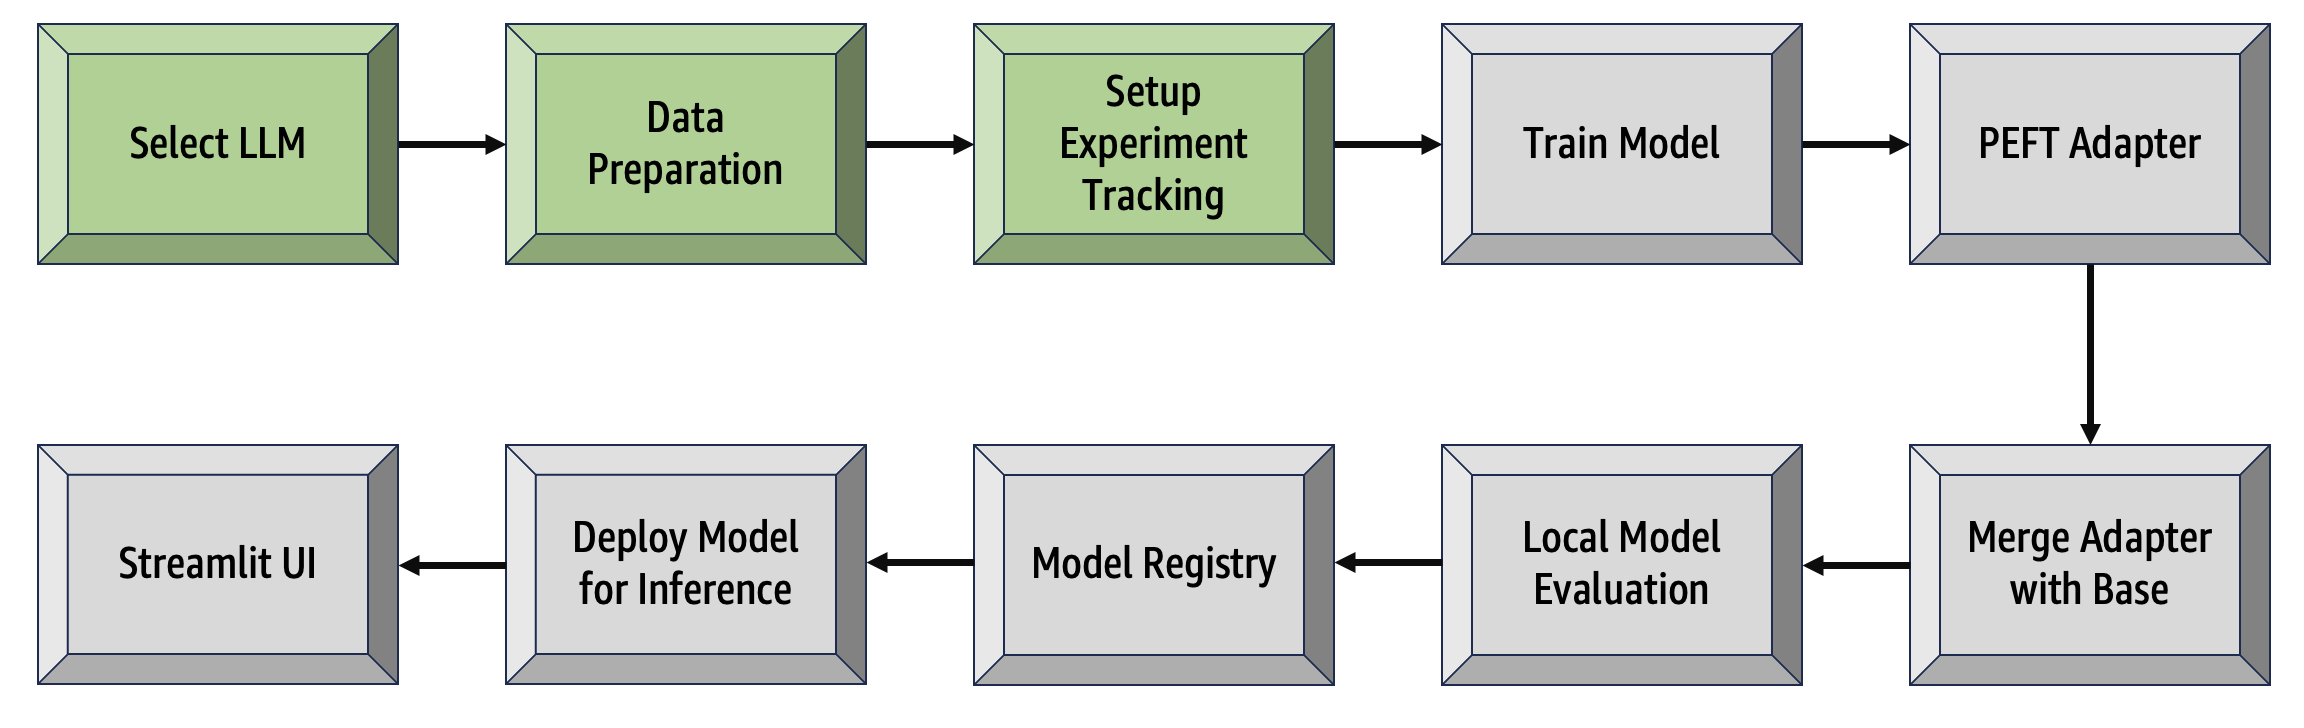

In [ ]:
import mlflow
from mlflow import MlflowClient

In [ ]:
os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"
mlflow.set_tracking_uri(TRACKING_SERVER_ARN)
experiment_info = mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

# Train or Fine-Tune your Model

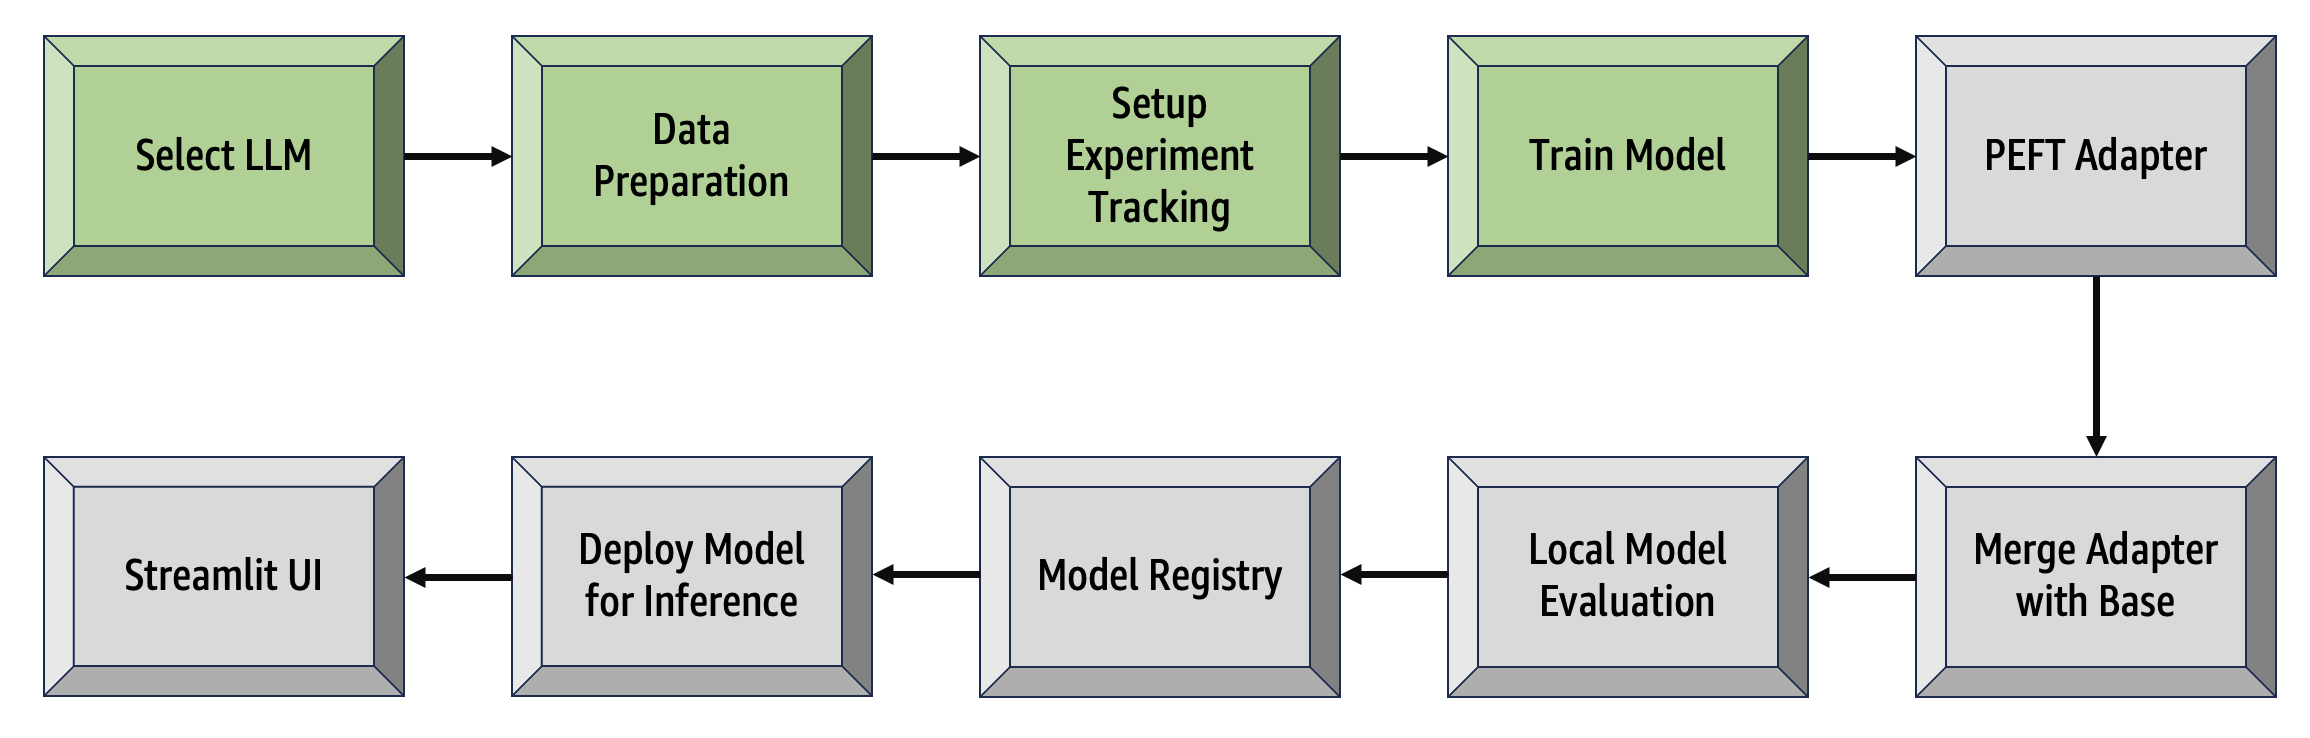

In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
config = LoraConfig(
    r=64,
    lora_alpha=128,
    target_modules="all-linear",
    lora_dropout=0.08,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

In [ ]:
accelerator = Accelerator()

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_info.experiment_id, 
    run_name=f"Llama3-8B-Finance-QLoRA-{datetime.now().strftime('%Y-%m-%d-%H-%M-%s')}"
) as run:
    training_args = transformers.TrainingArguments(
        report_to="mlflow",
        run_name=run.info.run_name,
        output_dir="/mnt/sagemaker-nvme/hf-models/fine-tuned/peft/",
        per_device_train_batch_size=3,
        per_device_eval_batch_size=3,
        gradient_accumulation_steps=2,
        gradient_checkpointing=True,
        optim="paged_adamw_8bit",
        bf16=True,
        learning_rate=8e-5,
        lr_scheduler_type="constant",
        max_steps=5,
        save_steps=25,
        logging_steps=1,
        warmup_steps=5,
        ddp_find_unused_parameters=False
    )
    
    trainer = accelerator.prepare(
        transformers.Trainer(
                model=model,
                train_dataset=lm_train_dataset,
                eval_dataset=lm_valid_dataset,
                data_collator=transformers.DataCollatorForLanguageModeling(
                    tokenizer, 
                    mlm=False
                ),
                args=training_args,
            )
     )
    
    # use_cache=True is incompatible with gradient checkpointing.
    model.config.use_cache = False

    # Train model
    trainer.train()
    
    TRAINING_RUN_ID = run.info.run_id

## View Experimentation Tracking Results

Gain access to MLFlow tracking server to view experiment + system metrics

# Save Fine-Tuned PEFT Adapter to Disk

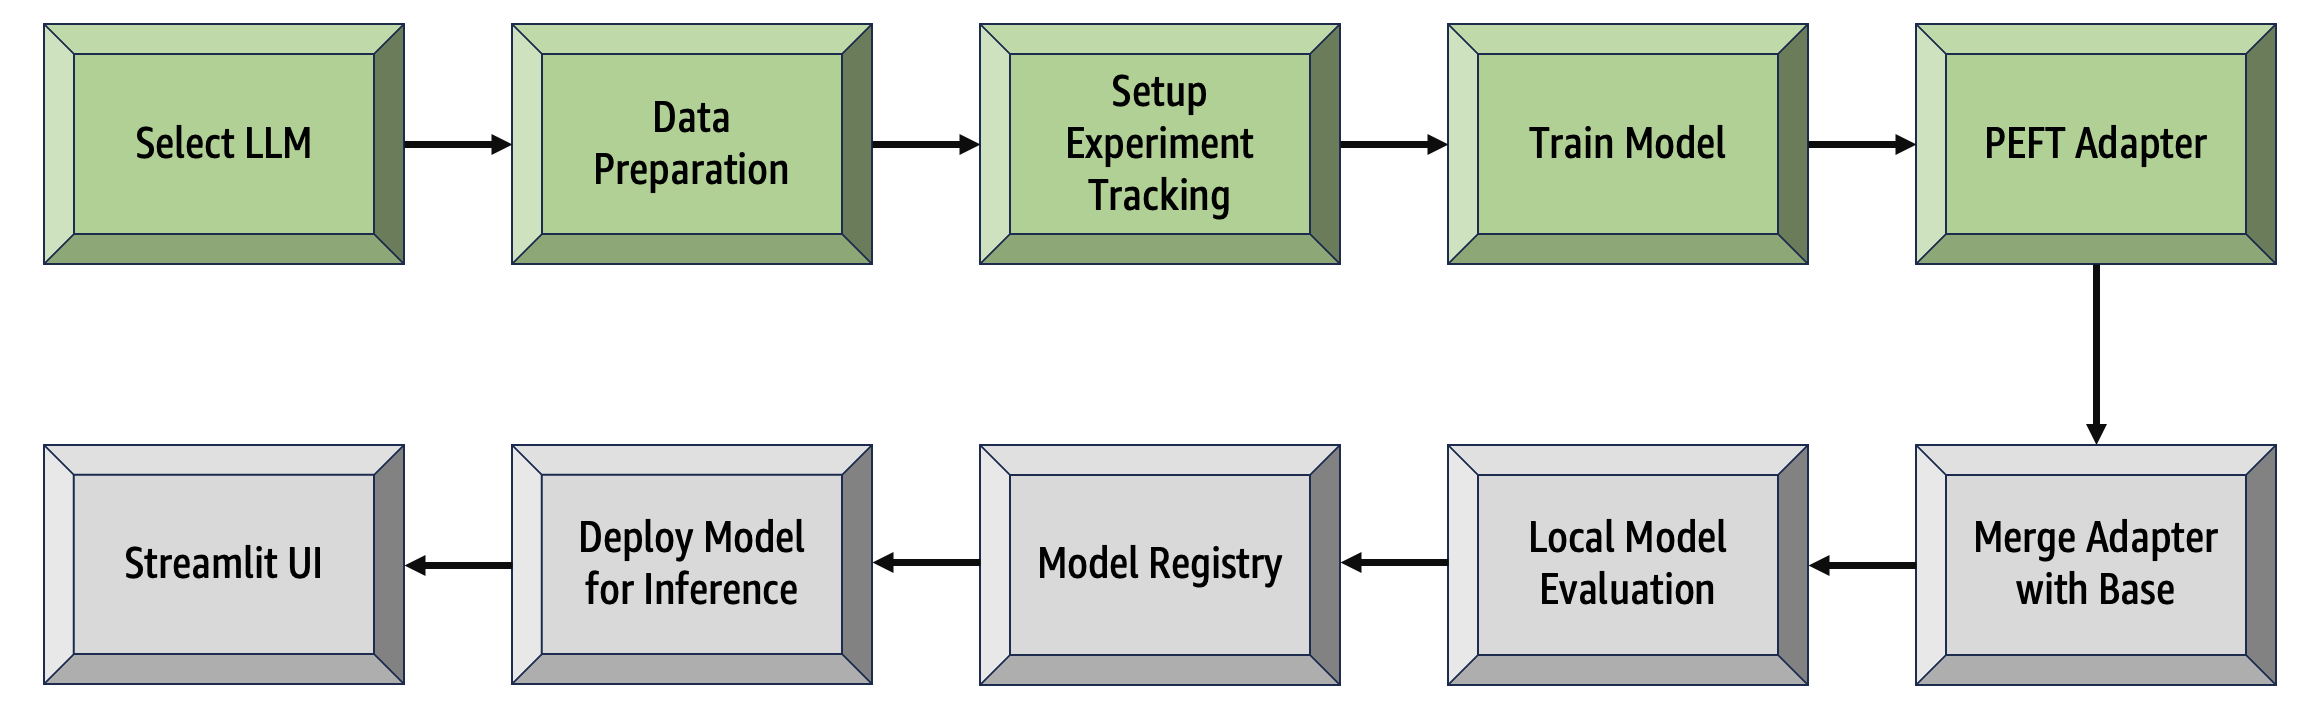

In [ ]:
temp_adapter_dir = "peft/adapter-model-dir"

In [ ]:
trainer.model.save_pretrained(
    temp_adapter_dir, 
    safe_serialization=False
)

In [ ]:
# clear memory
del model
del trainer
torch.cuda.empty_cache()
_ = gc.collect()

# Load PEFT Adapter and Merge with Base LLM

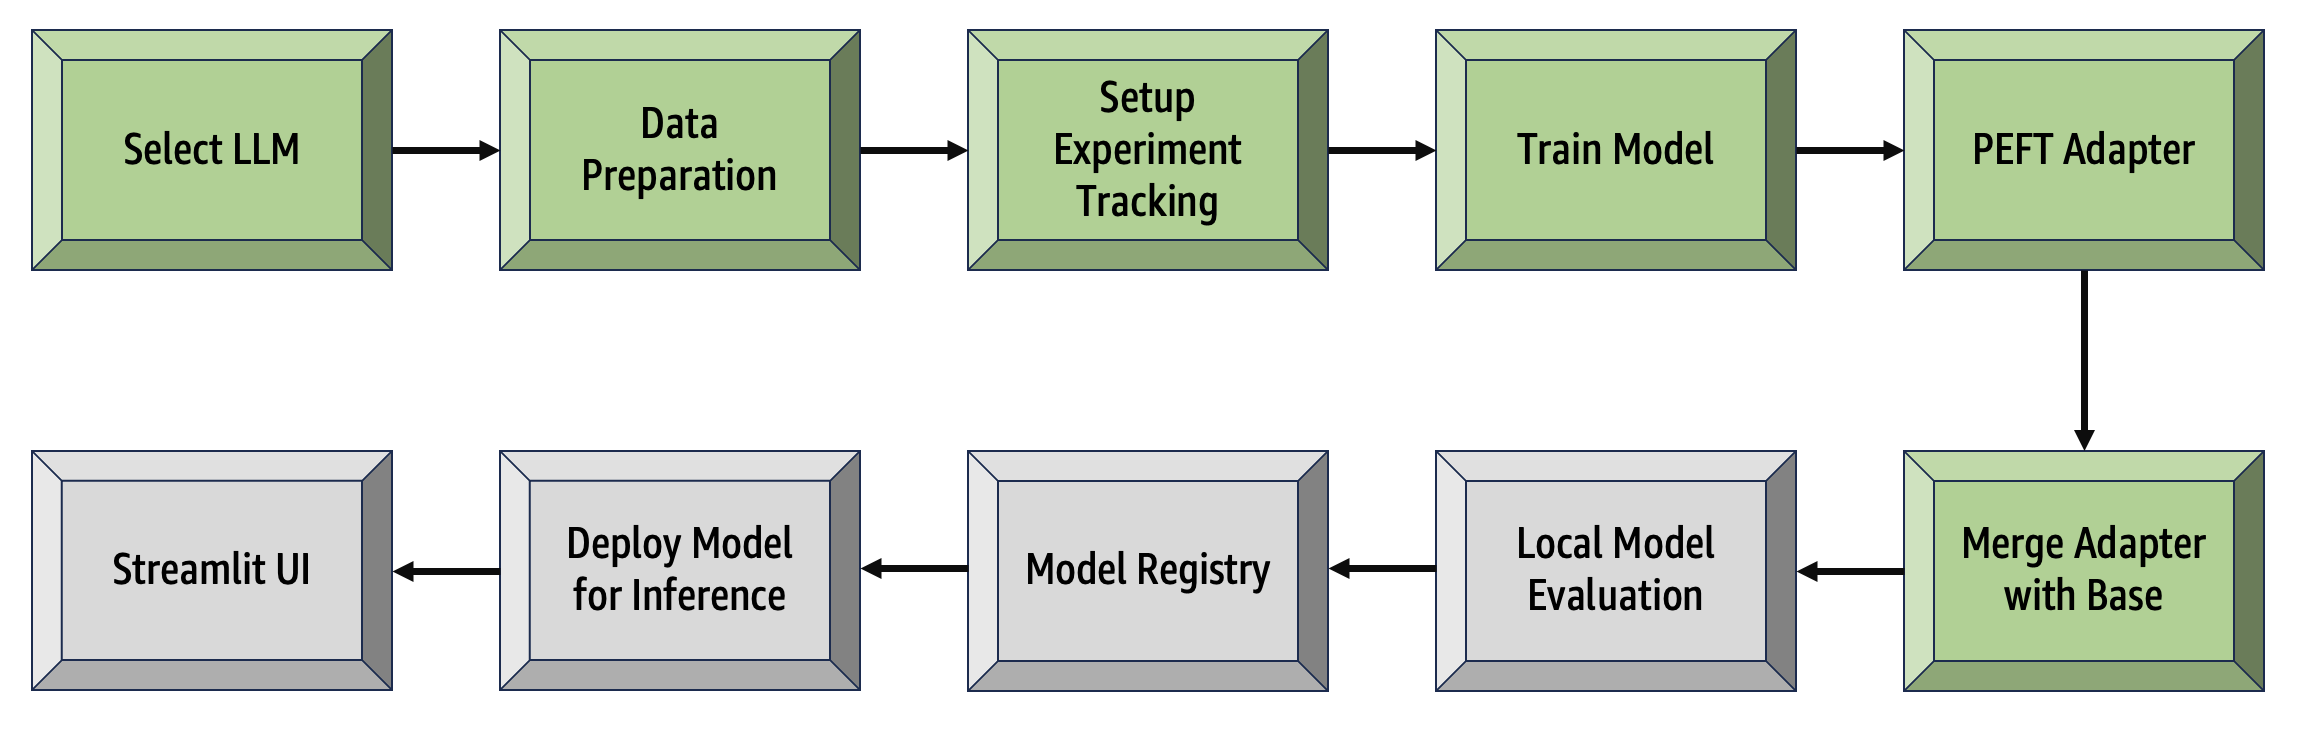

To bypass waiting for a model to be fined-tuned, we're going to use a pretrained adapter that was run for 5-6 hours beforehand to further the demonstration

In [ ]:
# pretrained model adapater directory
new_merged_model_dir = "meta-local/Llama3-finance-fine-tuned"
# DO NOT CHANGE THIS!
temp_adapter_dir = "pretrained-peft/checkpoint-v2-1200"

In [ ]:
# Load PEFT model on CPU
model = AutoPeftModelForCausalLM.from_pretrained(
    temp_adapter_dir,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    token=hf_token
)

In [ ]:
model = model.merge_and_unload()

In [ ]:
model.save_pretrained(
    new_merged_model_dir, 
    safe_serialization=True, 
    max_shard_size="9GB"
)
tokenizer.save_pretrained(
    save_directory=new_merged_model_dir, 
    from_pt=True
)

In [ ]:
# shutil.rmtree(temp_dir)

# Run Local Model Evaluation

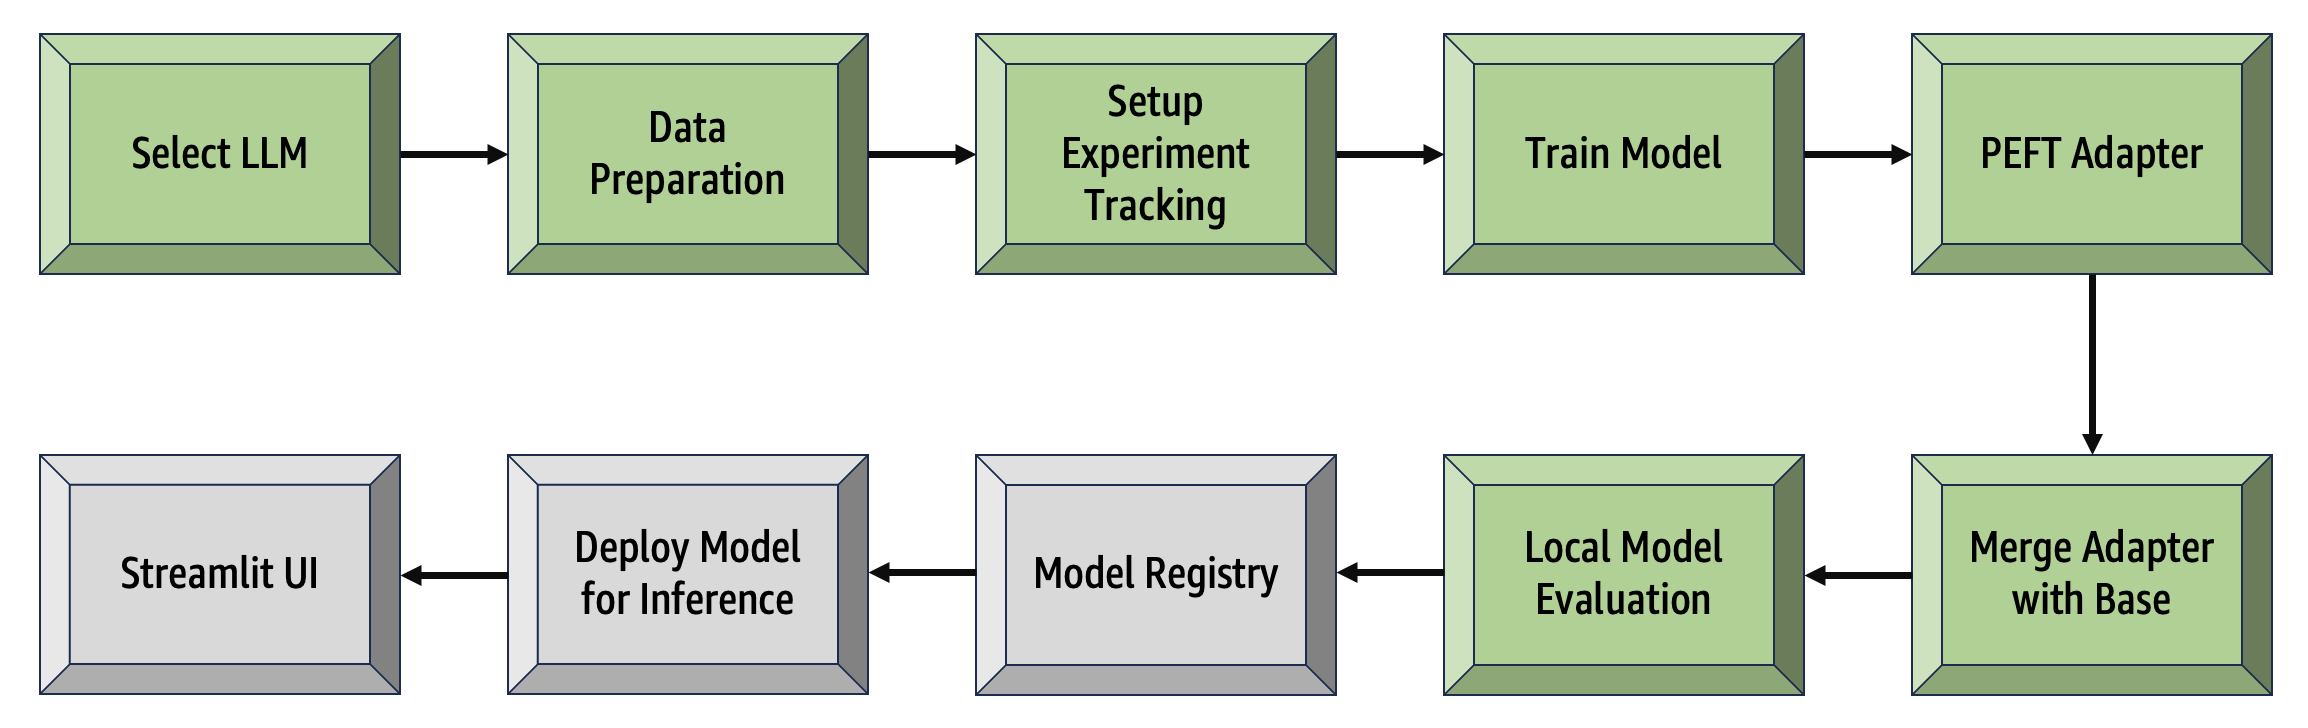

## Qualitative Evaluation

In [ ]:
del model
torch.cuda.empty_cache()
_ = gc.collect()

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    new_merged_model_dir,
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(
    new_merged_model_dir, 
    padding_side="left",
    add_eos_token=True
)
model.generation_config.pad_token_id = tokenizer.pad_token_id

In [ ]:
inference_dataset = load_dataset(
    DATASET_NAME, 
    split="test"
).rename_column("text", "context")

In [ ]:
inf_message, gt_response = llama3_prompt(
    inference_dataset[0], 
    test=True
)

In [ ]:
input_inference_ids = tokenizer.apply_chat_template(
    inf_message,
    add_generation_prompt=True,
    return_tensors="pt",
    tokenize=True
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

In [ ]:
outputs = model.generate(
    input_inference_ids,
    max_new_tokens=128,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.05,
    top_p=0.7
)
response = outputs[0][input_inference_ids.shape[-1]:]
llm_ft_response = tokenizer.decode(response, skip_special_tokens=True)

In [ ]:
pretty_print(llm_ft_response, gt_response)

## Quantitative Evaluation

In [ ]:
def run_inference(inference_prompt):
    inf_message, gt_response = llama3_prompt(inference_prompt, test=True)
    
    input_inference_ids = tokenizer.apply_chat_template(
        inf_message,
        add_generation_prompt=True,
        return_tensors="pt",
        tokenize=True
    ).to(model.device)
    
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_inference_ids,
        max_new_tokens=75,
        eos_token_id=terminators,
        do_sample=True,
        temperature=0.05,
        top_p=0.7
    )
    response = outputs[0][input_inference_ids.shape[-1]:]
    gen_response = tokenizer.decode(response, skip_special_tokens=True)

    return gen_response, gt_response


summary_pairs = []
eval_count = 15
for i in tqdm(range(0, eval_count), total=eval_count):
    gen_res, gt_resp = run_inference(inference_dataset[i])
    summary_pairs.append((gen_res, gt_resp))

In [ ]:
metrics = Metric_Evaluation()
df_metrics, df_metrics_raw = metrics.eval_bert_and_rouge_summary(summary_pairs)
eval_metrics = df_metrics_raw.mean().to_frame().rename(columns={0: "Metric Value"}).to_dict()['Metric Value']
print("Summarization Metrics for fine-tuned model as below:")
df_metrics

# Model Registry

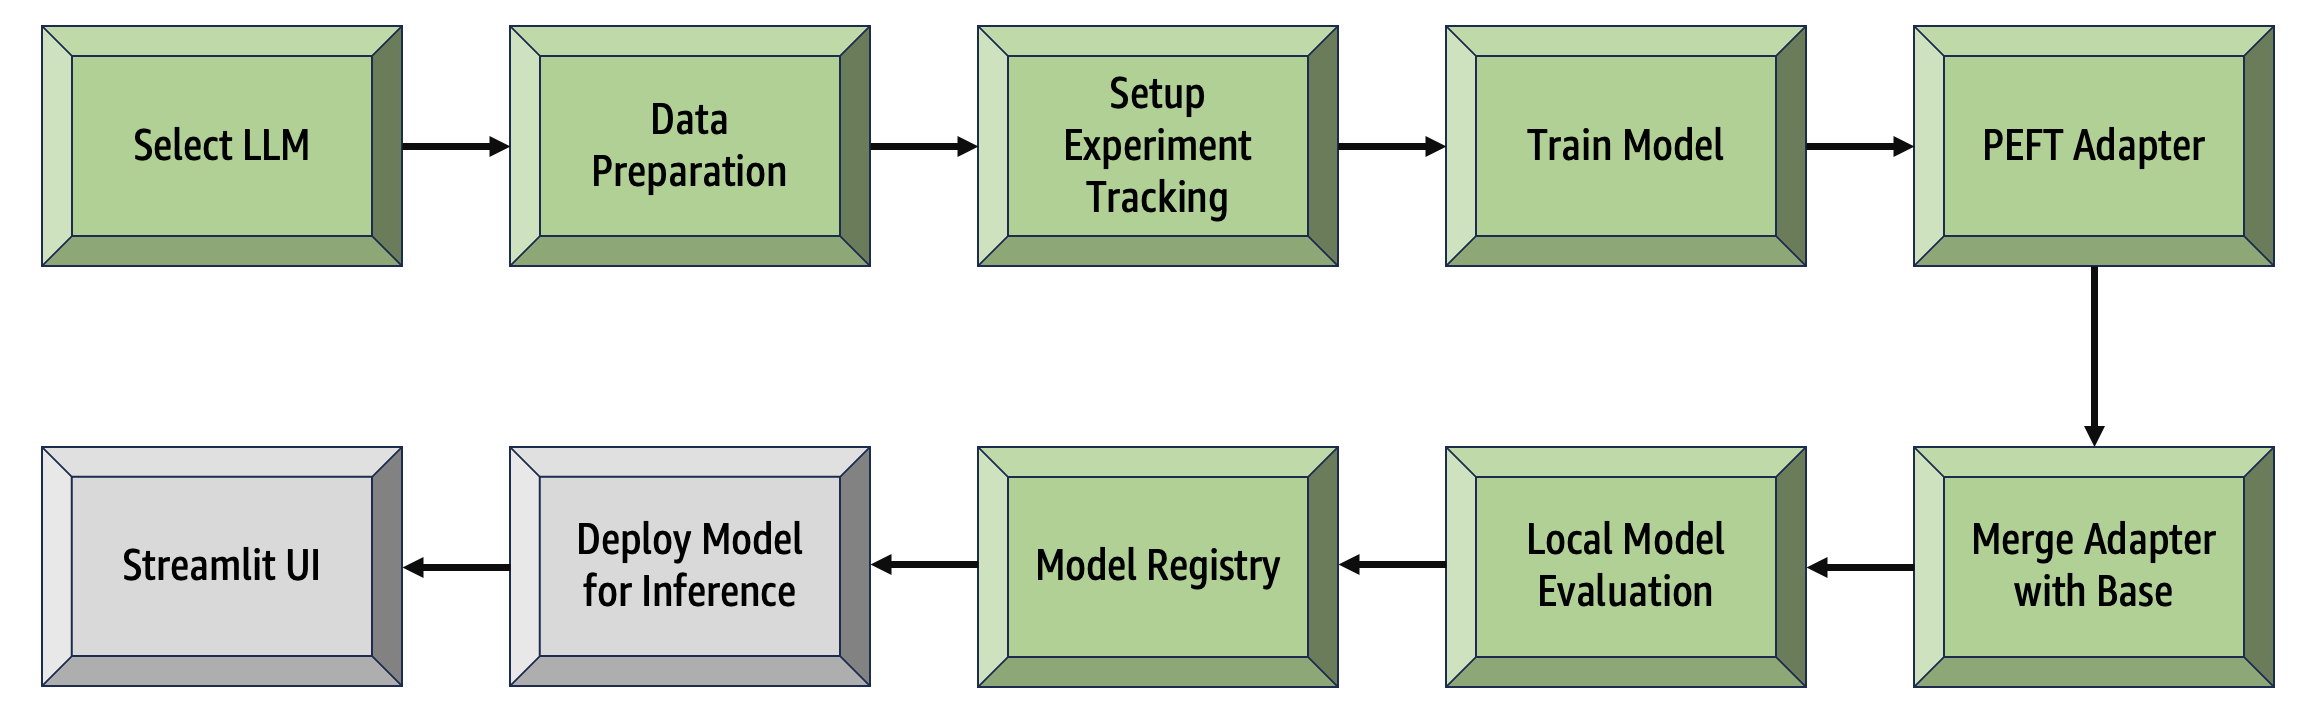

## Register a SageMaker Model

Create a `serving.properties` and `model.py` File

In [ ]:
import textwrap
import shutil

def create_djl_meta_model(ref_run_id, tar_model_path="model.tar.gz"):
    mlflow_client = MlflowClient()
    run = mlflow_client.get_run(ref_run_id)
    artifacts = mlflow_client.list_artifacts(ref_run_id)
    model_weights_s3_uri = None
    for artifact in artifacts:
        if artifact.path == "model_weights":
            model_weights_s3_uri = os.path.join(run.info.artifact_uri, artifact.path, os.path.basename(new_merged_model_dir))
            break
    print(f"model weights found: {model_weights_s3_uri}")

    # create and write serving properties file
    serving_properties = textwrap.dedent(f"""
    engine = Python
    option.s3url = {model_weights_s3_uri}/
    option.tensor_parallel_degree = 4
    """).strip()
    with open(
        os.path.join("./model", "serving.properties"), "w"
    ) as prop_file:
        prop_file.write(serving_properties)
    if os.path.exists("./model/.ipynb_checkpoints/"):
        shutil.rmtree("./model/.ipynb_checkpoints/")
    os.system(f"tar czvf {tar_model_path} model")
    return tar_model_path


def get_latest_approved_model_package_arn(model_package_group_name, suffix="1e9ff7"):
    model_package_group_name = f"{model_package_group_name}-{suffix}"
    # Describe the model package group to get details
    response = sm_client.describe_model_package_group(
        ModelPackageGroupName=model_package_group_name
    )
    
    # Get the list of model packages in the group
    list_response = sm_client.list_model_packages(
        ModelPackageGroupName=model_package_group_name,
        ModelApprovalStatus='Approved',  # Filter by approved models
        SortBy='CreationTime',  # Sort by creation time
        SortOrder='Descending'  # Get the latest first
    )
    # Check if any approved models are found
    if list_response['ModelPackageSummaryList']:
        latest_model_package = list_response['ModelPackageSummaryList'][0]
        latest_model_package_arn = latest_model_package['ModelPackageArn']
        model_data_uri = sm_client.describe_model_package(
            ModelPackageName=latest_model_package_arn
        )['SourceUri']
        model_data_uri = os.path.join(model_data_uri, "model.tar.gz")
        return latest_model_package_arn, model_data_uri
    else:
        return None, None

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_info.experiment_id, 
    # run_id=TRAINING_RUN_ID
    run_name="ModelRegistration"
) as run:
    
    mlflow.log_artifact(
        new_merged_model_dir, 
        artifact_path="model_weights"
    )
    tar_model_path = create_djl_meta_model(ref_run_id=run.info.run_id)
    mlflow.log_artifact(
        "model.tar.gz", 
        artifact_path="meta_model"
    )
    mlflow.log_metrics(
        {x.replace(' (', '-').replace(')', ''): eval_metrics[x] for x in eval_metrics}
    )
    model_uri = f"runs:/{run.info.run_id}/meta_model"
    registered_model = mlflow.register_model(
        model_uri=model_uri, 
        name=MODEL_PACKAGE_GROUP_NAME
    )

#### Get the last approved Model Package ARN

In [ ]:
latest_model_package_arn, model_data_uri = get_latest_approved_model_package_arn(MODEL_PACKAGE_GROUP_NAME)

if latest_model_package_arn:
    print(f"Latest approved model package ARN: {latest_model_package_arn}")
else:
    print("No approved models found in the package group.")

#### Inference Container URI

In [ ]:
from sagemaker import image_uris

inference_image_uri = image_uris.retrieve(
    framework="djl-deepspeed", 
    region=boto3.Session().region_name, 
    version="0.25.0"
)
print(f"Using container image: {inference_image_uri} for deployment!")

#### Update Registered Model

In [ ]:
response = sm_client.update_model_package(
    ModelPackageArn=latest_model_package_arn,
    InferenceSpecification={
        'Containers': [
            {
                'Image': inference_image_uri,
                'ModelDataUrl': model_data_uri
            },
        ],
        'SupportedTransformInstanceTypes': ['ml.g5.12xlarge', 'ml.p3.8xlarge'],
        'SupportedRealtimeInferenceInstanceTypes': ['ml.g5.12xlarge', 'ml.p3.8xlarge'],
        'SupportedContentTypes': ['application/json'],
        'SupportedResponseMIMETypes': ['application/json']
    }
)
model_package_arn = response["ModelPackageArn"]
print(f"update registered model's inference spec: {model_package_arn}")

# Deploy Model for Inference

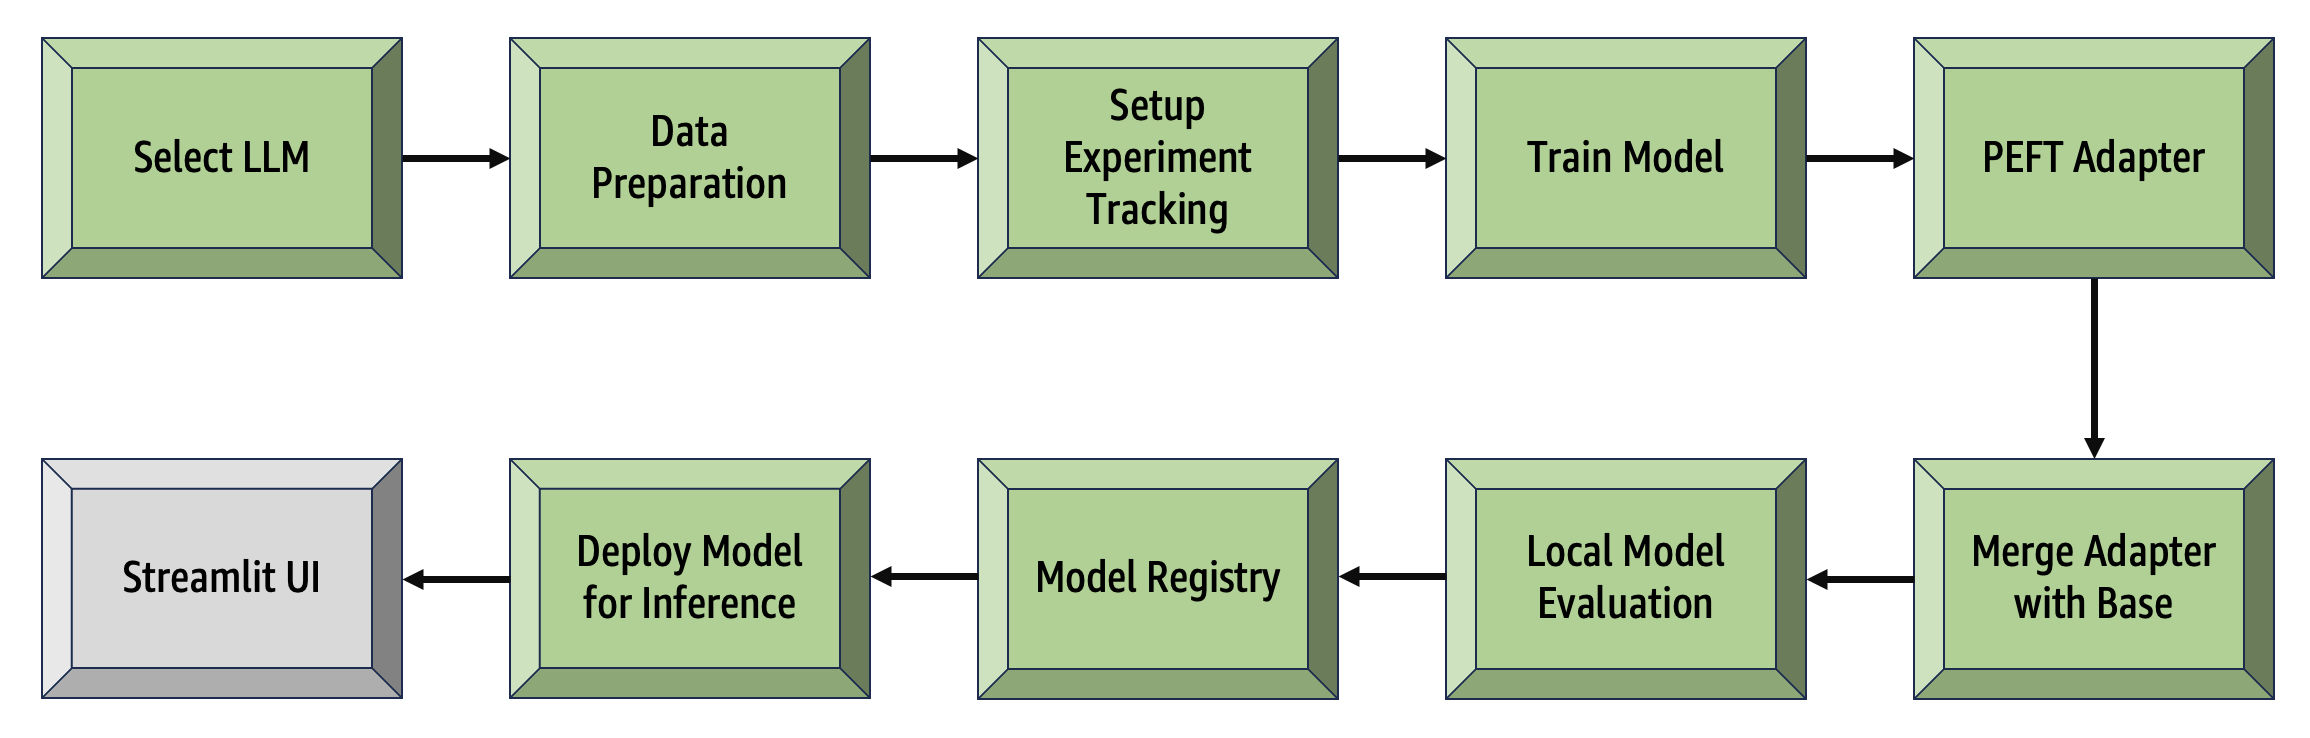

In [ ]:
from sagemaker.model import Model
from sagemaker import ModelPackage
from datetime import datetime

In [ ]:
ft_model = ModelPackage(
    model_package_arn=model_package_arn,
    sagemaker_session=sess,
    role=role,
    name=f"post-finetuned-llama3-8b-instruct-develop-v1",
)

In [ ]:
print(f"Deploying model with endpoint name ep-{ft_model.name}")
ft_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.12xlarge",
    endpoint_name=f"{ft_model.name}",
    container_startup_health_check_timeout=900,
    wait=False
)
print(f"\nEndpoint deployed ===>", ft_model.endpoint_name)

## Test Inference

In [ ]:
import sagemaker
from sagemaker import serializers, deserializers

In [ ]:
ft_predictor = sagemaker.Predictor(
    endpoint_name=ft_model.endpoint_name,
    sagemaker_session=sess,
    serializer=serializers.JSONSerializer(),
    deserializer=deserializers.JSONDeserializer(),
)

In [ ]:
chosen_idx = 0
prompt = inference_dataset[chosen_idx]['context']
gt_inf_response = inference_dataset[chosen_idx]['summary']

In [ ]:
print(prompt)

In [ ]:
parameters =  {
    "max_new_tokens": 128, 
    "do_sample": False, 
    "temperature": 0.05, 
    "top_p": 0.7,
}

In [ ]:
response = ft_predictor.predict(
    {
        "input": prompt,
        "properties": parameters
    }
)

In [ ]:
pretty_print(response['generated_text'], gt_inf_response)

# Streamlit UI

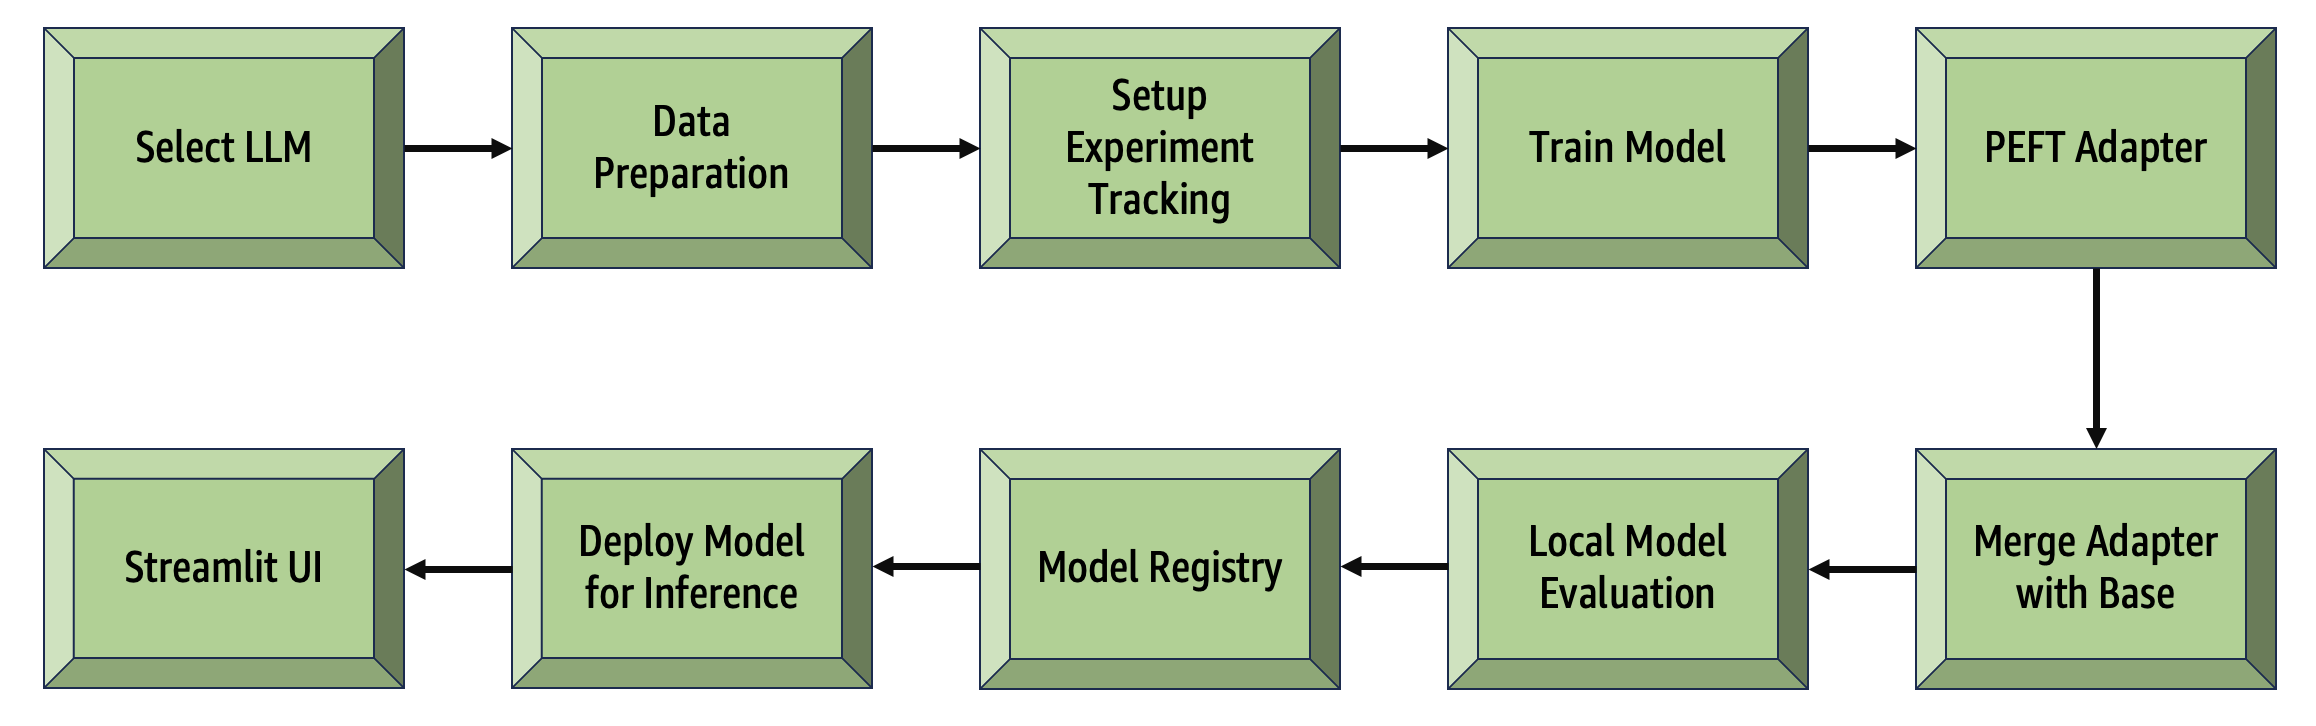

In [ ]:
%%bash
sudo apt-get install -yq jq

In [ ]:
%%bash
DOMAIN_ID=$(jq -r '.DomainId' /opt/ml/metadata/resource-metadata.json)
SPACE_NAME=$(jq -r '.SpaceName' /opt/ml/metadata/resource-metadata.json)
STREAMLIT_URL=$(aws sagemaker describe-space --domain-id $DOMAIN_ID --space-name $SPACE_NAME | jq -r '.Url')

echo "=====>  Launch Streamlit: $STREAMLIT_URL/proxy/8501/"

streamlit run ~/aim302-code-talk/chat_app.py --server.runOnSave true --server.port 8501 > /dev/null